In [23]:
#importing some useful packages
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC, SVC
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.utils import shuffle
from IPython.display import HTML
import numpy as np
from collections import deque
import pickle
import cv2
import glob
import time
%matplotlib inline  

In [24]:
# balanced quantity of 2 sets
carset = glob.glob('vehicles/GTI_Far/*.png')
carset += glob.glob('vehicles/GTI_MiddleClose/*.png')
carset += glob.glob('vehicles/GTI_Left/*.png')
carset += glob.glob('vehicles/GTI_Right/*.png')
carset += glob.glob('vehicles/KITTI_extracted/*.png')

notcarset = glob.glob('./non-vehicles/Extras/*.png')
notcarset += glob.glob('./non-vehicles/GTI/*.png')

print(len(carset))
print(len(notcarset))

8792
8968


In [25]:
# arrange all datasets 
carset0 = glob.glob('vehicles/GTI_Far/*.png')
carset1 = glob.glob('vehicles/GTI_MiddleClose/*.png')
carset2 = glob.glob('vehicles/GTI_Left/*.png')
carset3 = glob.glob('vehicles/GTI_Right/*.png')
carset4 = glob.glob('vehicles/KITTI_extracted/*.png')

In [26]:
segment_factor1 = 0.7
segment_factor2 = 0.9

# restruct the dataset layout

Set0,Set1,Set2,Set3,Set4,Set5=len(carset0),len(carset1),len(carset2),len(carset3),len(carset4),len(notcarset)
S1 = (segment_factor1*np.array([Set0,Set1,Set2,Set3,Set4,Set5])).astype('int')
S2 = (segment_factor2*np.array([Set0,Set1,Set2,Set3,Set4,Set5])).astype('int')

# 70% train set, 20& validation set, 10% test set
trainset = carset0[:S1[0]] + carset1[:S1[1]] + carset2[:S1[2]] + carset3[:S1[3]] + carset4[:S1[4]]
notcar_trainset = notcarset[:S1[5]]

valset = carset0[S1[0]:S2[0]] + carset1[S1[1]:S2[1]] + carset2[S1[2]:S2[2]] + carset3[S1[3]:S2[3]] + carset4[S1[4]:S2[4]]
notcar_valset = notcarset[S1[5]:S2[5]]

testset = carset0[S2[0]:] + carset1[S2[1]:] + carset2[S2[2]:] + carset3[S2[3]:] + carset4[S2[4]:]
notcar_testset = notcarset[S2[5]:]

In [27]:
# save data for a easy handling in the future
pickle_output = 'data.p'
try:
    with open(pickle_output, 'wb') as pfile:
        pickle.dump(
            {
                'car_train': trainset,
                'noncar_train': notcar_trainset,
                'car_val': valset,
                'noncar_val': notcar_valset,
                'car_test': testset,
                'noncar_test': notcar_testset
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_output, ':', e)
    raise
print('data cached in pickle')

data cached in pickle


In [28]:
data_input = 'data.p'
with open(data_input, mode='rb') as f:
    data = pickle.load(f)
car_train = data['car_train']
noncar_train = data['noncar_train']
car_val = data['car_val']
noncar_val = data['noncar_val']
car_test = data['car_test']
noncar_test = data['noncar_test']

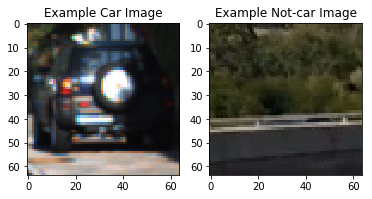

In [29]:
# find to shuffle images for car / noncar pools.
car_ind = np.random.randint(0, len(car_train))
noncar_ind = np.random.randint(0, len(noncar_train))
# Read in car / not-car images
car_image = mpimg.imread(car_train[car_ind])
noncar_image = mpimg.imread(noncar_train[noncar_ind])
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(noncar_image)
plt.title('Example Not-car Image')

In [91]:
def bin_spatial(img, color_space='RGB', size=(16, 16)):
    # Convert image to new color space (if specified)          
    if color_space != 'RGB':
        feature_image = cv2.cvtColor (img, getattr(cv2, 'COLOR_RGB2' + color_space))
        
    else: feature_image = np.copy(img)  
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

# print(bin_spatial(car_image,color_space='RGB'))
len(bin_spatial(car_image,color_space='RGB'))

768

In [85]:
def color_hist(img, nbins=32, color_space='RGB',bins_range=(0, 1)):
    
    if color_space != 'RGB':
        feature_image = cv2.cvtColor (img, getattr(cv2, 'COLOR_RGB2' + color_space))
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

hist_features = color_hist(car_image)
print(hist_features)
len(hist_features)

[ 75 780 460 378 265 233 217 188 147 107  92  64  35  42  42  33  29  38
  42  32  44  78 108 109 123  85  64  50  21  14  12  89  57 713 478 326
 270 248 226 198 159  98  95  82  64  85  62  50  35  29  45  66 103 127
 114  95  63  41  33   5  14  11  20  84  13 583 665 284 277 270 240 175
 129 112  82  76  66  71  70  79  43  49  83 117 136  89 101  58  35  25
  16  14  12  11  17  98]


96

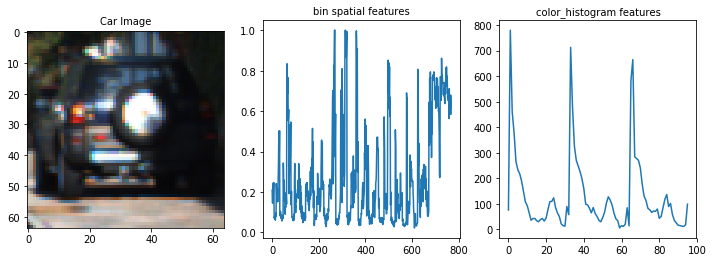

In [92]:
spatial_features = bin_spatial(car_image)
xVec = np.vstack((spatial_features)).astype(np.float64)  

hist_features = color_hist(car_image)
yVec = np.vstack((hist_features)).astype(np.float64) 


fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(car_image, cmap='gray')
plt.title('Car Image',fontsize=10)
plt.subplot(132)
plt.plot(xVec)
plt.title('bin spatial features',fontsize=10)
plt.subplot(133)
plt.plot(yVec)
plt.title('color_histogram features',fontsize=10)
plt.savefig('examples/bin_spatial_features.png')

In [199]:
color_space = 'YCrCb' # Can be GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (8, 8) # Spatial binning dimensions
hist_bins = 32   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hist_range = (0,256)
hog_feat = True # HOG features on or off

car_image_single_channel = car_image[:,:,2]
features, hog_image = hog(car_image_single_channel, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)

In [200]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
hog_features = get_hog_features(car_image_single_channel,pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,orient=orient)
# print(hog_features)
len(hog_features)

288

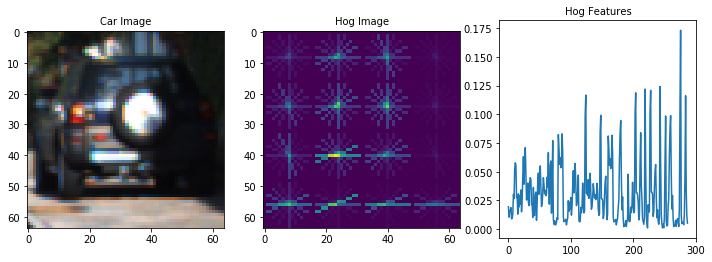

In [201]:
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(car_image, cmap='gray')
plt.title('Car Image',fontsize=10)
plt.subplot(132)
plt.imshow(hog_image)
plt.title('Hog Image',fontsize =10)
plt.subplot(133)
plt.plot(hog_features)
plt.title('Hog Features',fontsize=10)
plt.savefig('examples/hog_features.png')

In [202]:
def single_img_features(img, color_space= color_space, spatial_size= spatial_size,
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat):    
          
    features = []
    
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        feature_image = cv2.cvtColor (img, getattr(cv2, 'COLOR_RGB2' + color_space))

    
    else: feature_image = np.copy(img)      
    # Compute spatial features
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        features.append(spatial_features)
        
    # Compute histogram features 
    if hist_feat == True:
        hist_features = color_hist(feature_image, color_space = 'HLS', nbins=hist_bins)
        features.append(hist_features)
        
    # Compute HOG features 
    if hog_feat == True:
        if color_space == 'GRAY':
            hog_features = get_hog_features(feature_image, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        elif hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        features.append(hog_features)
        
    return np.concatenate(features)

print(single_img_features(car_image))
len(single_img_features(car_image))

[ 0.31583825  0.50688183  0.42637312 ...,  0.02626602  0.02574362
  0.00818719]


1152

In [203]:
def extract_features(imgs, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat):

    features = []
    # Iterate  for images
    for img in imgs:
        image_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = cv2.cvtColor(img, getattr(cv2, 'COLOR_RGB2'+color_space))
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            image_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, color_space = 'HLS',nbins=hist_bins)
            image_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if color_space == 'GRAY':
                hog_features = get_hog_features(feature_image, orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            elif hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            image_features.append(hog_features)
        features.append(np.concatenate(image_features))
    # Return list of feature vectors
    return features

In [204]:
# training set
car_image_train = []
for impath in car_train:
    car_image_train.append (mpimg.imread(impath))

noncar_image_train = []
for impath in noncar_train:
    noncar_image_train.append (mpimg.imread(impath)) 
    
car_image_train_count = len (car_image_train)
noncar_image_train_count = len (noncar_image_train)

print ('car trainset counts:', car_image_train_count)
print ('noncar trainset counts:', noncar_image_train_count)

# validation set
car_image_validation = []
for impath in car_val:
    car_image_validation.append (mpimg.imread(impath))

noncar_image_validation = []
for impath in noncar_val:
    noncar_image_validation.append (mpimg.imread(impath)) 
    
car_image_validation_count = len (car_image_validation)
noncar_image_validation_count = len (noncar_image_validation)

print ('car validationset counts:', car_image_validation_count)
print ('noncar velidationset counts:', noncar_image_validation_count)

# test set
car_image_test = []
for impath in car_test:
    car_image_test.append (mpimg.imread(impath))

noncar_image_test = []
for impath in noncar_test:
    noncar_image_test.append (mpimg.imread(impath)) 
    
car_image_test_count = len (car_image_test)
noncar_image_test_count = len (noncar_image_test)

print ('car testset counts:', car_image_test_count)
print ('noncar testset counts:', noncar_image_test_count)

car trainset counts: 6152
noncar trainset counts: 6277
car validationset counts: 1759
noncar velidationset counts: 1794
car testset counts: 881
noncar testset counts: 897


In [205]:
# extract all the feasures from all 6 datasets for later training and validation. 

ft=time.time()
car_train_features = extract_features(car_image_train, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
car_validation_features = extract_features(car_image_validation, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
car_test_features = extract_features(car_image_test, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
noncar_train_features = extract_features(noncar_image_train, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
noncar_validation_features = extract_features(noncar_image_validation, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
noncar_test_features = extract_features(noncar_image_test, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
ft2=time.time()
print ('features extraction time: ', round(ft2-ft, 2))

features extraction time:  42.17


In [206]:
# normalize all dataset feasures 
X = np.vstack((car_train_features,car_validation_features,car_test_features,
              noncar_train_features,noncar_validation_features,noncar_test_features)).astype(np.float64)

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_train_features)+len(car_validation_features)+len(car_test_features)), 
               np.zeros(len(noncar_train_features)+len(noncar_validation_features)+len(noncar_test_features))))

In [207]:
# prepre for later used to manipulate the datasets
n1=len(car_train_features)
n2=len(car_validation_features)
n3=len(car_test_features)
n4=len(noncar_train_features)
n5=len(noncar_validation_features)
n6=len(noncar_test_features)

In [210]:
# split to 3 datasets from the initial image groups.  

car_train_features,car_validation_features,car_test_features = scaled_X[:n1],scaled_X[n1:n1+n2],scaled_X[n1+n2:n1+n2+n3]
noncar_train_features,noncar_validation_features,noncar_test_features = scaled_X[n1+n2+n3:n1+n2+n3+n4],scaled_X[n1+n2+n3+n4:n1+n2+n3+n4+n5],scaled_X[n1+n2+n3+n4+n5:]

y_train = np.hstack((np.ones(n1), np.zeros(n4)))
y_val = np.hstack((np.ones(n2), np.zeros(n5)))
y_test = np.hstack((np.ones(n3), np.zeros(n6)))

# mix car and noncar images
X_train = np.vstack((scaled_X[:n1],scaled_X[n1+n2+n3:n1+n2+n3+n4]))
X_val = np.vstack((scaled_X[n1:n1+n2],scaled_X[n1+n2+n3+n4:n1+n2+n3+n4+n5]))
X_test = np.vstack((scaled_X[n1+n2:n1+n2+n3],scaled_X[n1+n2+n3+n4+n5:]))

X_train,y_train = shuffle(X_train,y_train,random_state=42)
X_val,y_val = shuffle(X_val,y_val,random_state=42)
X_test,y_test = shuffle(X_test,y_test,random_state=42)

print('Feature vector length:', len(X_train[0]))

print('Train dataset lentgh:',len(X_train))
print('Train dataset lentgh:',len(X_val))
print('Train dataset lentgh:',len(X_test))

Feature vector length: 1152
Train dataset lentgh: 12429
Train dataset lentgh: 3553
Train dataset lentgh: 1778


In [211]:
# train the svc classifiers
# svc = SVC(C=1.5,cache_size=200,class_weight=None,coef0=0.0,decision_function_shape='ovr',degree=3,gamma='auto',
#          kernel='rbf',max_iter=-1,probability=False,random_state=None,shrinking=True,tol=0.001,verbose=False)

svc = SVC()

t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

# Check the score of the SVC
print('color_space =',color_space)
print('hog channel =',hog_channel)
print('Validation Accuracy of SVC = ', round(svc.score(X_val, y_val), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
print(round(t2-t,2),'Seconds.')

color_space = YCrCb
hog channel = ALL
Validation Accuracy of SVC =  0.9696
Test Accuracy of SVC =  0.9235
31.07 Seconds.


Test log:hog_features = True, hist_features = True, spatial_features = True

color_space = HSV; hog channel = 2;Validation Accuracy of SVC =  0.9825;Test Accuracy of SVC =  0.9584

color_space = GRAY; Validation Accuracy of SVC =  0.9766;Test Accuracy of SVC =  0.9415;

color_sapce = HSV, hog channel = 'ALL'; Val Accracy = 0.984, Test Accu = 0.964

color_space = YCrCb, hog channel = 'ALL'; VA = 0.982; TA = 0.964

color_space = YCrCb, hot channel = 1, VA = 0.9665; TA = 0.946

color_space = YCrCb, hot_channel = 0; pixel_per_cell = 16, VA = 0.9769; TA = 0.9438

color_space = HSV, hot_channel = 2; pixel_per_cell = 16, VA = 0.9809; TA = 0.9629

color_space = LUV for HOG and Spatial, HLS for Color_hist, 'ALL'; VA = 0.9823, TA = 0.955

color_space = YCrCb for HOG and Spatial, HLS for Color_hist, 'ALL'; VA = 0.98; TA= 0.9567 

test log:  hog_features = True, hist_features = False, spatial_features = False 

YCrCb Color space. Validation Accuracy of SVC =  0.9583;Test Accuracy of SVC =  0.9055;9.56 Seconds to train SVC...
YUV Color space.   Validation Accuracy of SVC =  0.9541;Test Accuracy of SVC =  0.8982;9.05 Seconds to train SVC...
HSV Color space.   Validation Accuracy of SVC =  0.9657;Test Accuracy of SVC =  0.9083;8.97 Seconds to train SVC...
HLS Color space.   Validation Accuracy of SVC =  0.9609;Test Accuracy of SVC =  0.9111;9.48 Seconds to train SVC...
LUV Color space.   Validation Accuracy of SVC =  0.9792;Test Accuracy of SVC =  0.9348;11.27 Seconds to train SVC...
GRAY Color space.  Validation Accuracy of SVC =  0.9823;Test Accuracy of SVC =  0.9753;4.02 Seconds to train SVC...

test log(Color space = HLS): 

hog channels = 2: Validation Accuracy of SVC =  0.9105; Test Accuracy of SVC =  0.8971; 7.56 Seconds to train SVC...
hog channels = 1: Validation Accuracy of SVC =  0.984;  Test Accuracy of SVC =  0.9775; 3.91 Seconds to train SVC...
hog channels = 0: Validation Accuracy of SVC =  0.8829; Test Accuracy of SVC =  0.8166; 6.81 Seconds to train SVC...

test log(Color space = HSV): 

hog channels = 2: Validation Accuracy of SVC =  0.9842;Test Accuracy of SVC =  0.9781; 3.5 Seconds to train SVC...
hog channels = 1: Validation Accuracy of SVC =  0.9001;Test Accuracy of SVC =  0.8937; 6.58 Seconds to train SVC...
hot channels = 0: Validation Accuracy of SVC =  0.8798;Test Accuracy of SVC =  0.8183; 6.73 Seconds to train SVC...

test log(Color space = LUV):

hog channels = 2: Validation Accuracy of SVC =  0.8925; Test Accuracy of SVC =  0.8487; 6.79 Seconds to train SVC...
hog channels = 1: Validation Accuracy of SVC =  0.8902; Test Accuracy of SVC =  0.8335; 8.73 Seconds to train SVC...
hog channels = 0: Validation Accuracy of SVC =  0.9817; Test Accuracy of SVC =  0.9747; 3.95 Seconds to train SVC...

test log(Color space = YUV):

hog channels = 2: Validation Accuracy of SVC =  0.8458; Test Accuracy of SVC =  0.8093; 5.36 Seconds to train SVC...
hog channels = 1: Validation Accuracy of SVC =  0.8562; Test Accuracy of SVC =  0.8043; 6.54 Seconds to train SVC...
hog channels = 0: Validation Accuracy of SVC =  0.9831; Test Accuracy of SVC =  0.9719; 3.81 Seconds to train SVC...

test log(Color space = YCrCb):

hog channels = 2: Validation Accuracy of SVC =  0.8559; Test Accuracy of SVC =  0.8121; 5.24 Seconds to train SVC...
hog channels = 1: Validation Accuracy of SVC =  0.8393; Test Accuracy of SVC =  0.7897; 7.32 Seconds to train SVC...
hog channels = 0: Validation Accuracy of SVC =  0.9823; Test Accuracy of SVC =  0.9753; 3.98 Seconds to train SVC...

In [212]:
print('SVC predict:',svc.predict(X_test[0:100]))
print('For  labels:',y_test[0:100])

SVC predict: [ 0.  1.  0.  1.  1.  1.  1.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  1.
  0.  0.  1.  1.  0.  1.  0.  1.  0.  1.  1.  0.  0.  1.  0.  1.  1.  0.
  0.  1.  1.  0.  1.  0.  1.  1.  0.  0.  0.  1.  1.  0.  0.  1.  1.  0.
  0.  0.  1.  1.  1.  0.  0.  0.  0.  1.  1.  0.  1.  1.  1.  1.  1.  0.
  0.  1.  0.  0.  0.  1.  1.  0.  1.  1.  0.  1.  0.  1.  0.  1.  0.  0.
  1.  1.  0.  1.  1.  1.  0.  1.  0.  1.]
For  labels: [ 0.  1.  0.  1.  1.  1.  1.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  1.
  0.  0.  1.  1.  0.  1.  0.  1.  0.  1.  1.  0.  0.  1.  0.  1.  1.  0.
  0.  1.  1.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.
  0.  0.  1.  1.  1.  0.  0.  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.  0.
  0.  1.  0.  0.  0.  1.  1.  0.  1.  1.  0.  1.  0.  1.  0.  1.  0.  0.
  1.  1.  0.  1.  1.  1.  0.  1.  1.  1.]


In [213]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):

    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = 1280
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = 720
        
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [214]:
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
#         print(len(features))
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
#         len(test_features)
        
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


In [215]:
def draw_boxes(img, bboxes):
    imgcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imgcopy, bbox[0], bbox[1], (0,0,255), 6)
    return imgcopy

In [216]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [217]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image
    return img

In [218]:
def multi_slide_windows(image):
    
    windows = []
#min of X set to 400, in order to save the computational lead time, or else I have to process the video up to 5 hours!
#     X_start_stop =[[400,None],[400,None],[400,None],[420,None]]
#     XY_window = [(180,180),(128,128),(96,96),(80,80)]
#     XY_overlap = [(0.75,0.75),(0.75,0.75),(0.75,0.75),(0.75,0.75)]                
#     Y_start_stop =[[380,680],[380,640],[395,600],[400,540]]  

# test with fewer scaled blocks to save the computational load. 
     
    X_start_stop =[[400,None],[400,None],[420,None]]
    XY_window = [(128,128),(96,96),(80,80)]
    XY_overlap = [(0.75,0.75),(0.75,0.75),(0.75,0.75)]                
    Y_start_stop =[[380,640],[395,600],[400,540]]
    
    
    for i in range(len(Y_start_stop)):
        window = slide_window(image, x_start_stop=X_start_stop[i], y_start_stop=Y_start_stop[i], 
                            xy_window=XY_window[i], xy_overlap=XY_overlap[i])
        
        windows += window
        
    return windows

2.4 Seconds to calculate heatmap image...


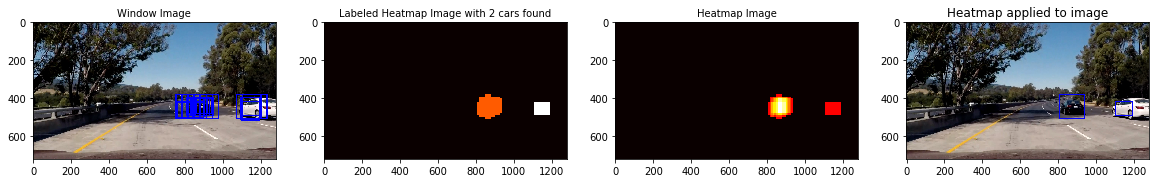

In [219]:
t=time.time()

# demo image for the pipeline buildup
image = mpimg.imread('test_images/test5.jpg')
draw_image = np.copy(image)
trial_image = draw_image.astype(np.float32)/255

# threshold value used to filter out false positives
heat_threshold = 3

#  sliding window groups under multiple size
windows = multi_slide_windows(trial_image)

# classifier to get all hot windows for true positive feature 
hot_windows = search_windows(trial_image, windows, svc, X_scaler, color_space=color_space,
                         spatial_size=spatial_size, hist_bins=hist_bins,
                         orient=orient, pix_per_cell=pix_per_cell,
                         cell_per_block=cell_per_block,
                         hog_channel=hog_channel, spatial_feat=spatial_feat,
                         hist_feat=hist_feat, hog_feat=hog_feat)


# draw hot images into original image
window_img = draw_boxes(draw_image, hot_windows)


# plt.imshow(window_img)
# creat heatmap
heat = np.zeros_like(window_img[:,:,0]).astype(np.float)
# padding color
heatmap = add_heat(heat, hot_windows)
# filter out false positive feature windows
heatmap = apply_threshold(heatmap, heat_threshold)
# label out the hot image cluster. i.e. quantity of objects
labels = label(heatmap)
# draw blocks into original image, 
applied_image = draw_labeled_bboxes(draw_image, labels)

# plot the whole process flow
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
ax1.imshow(window_img)
ax1.set_title('Window Image', fontsize=10)
ax2.imshow(labels[0], cmap='hot')
ax2.set_title('Labeled Heatmap Image with {} cars found'.format(labels[1]), fontsize=10)
ax3.imshow(heatmap, cmap='hot')
ax3.set_title('Heatmap Image', fontsize=10)
ax4.imshow(applied_image)
ax4.set_title('Heatmap applied to image')


t2 = time.time()
print(round(t2-t,2),'Seconds to calculate heatmap image...')

In [220]:
def draw_words(img, car_count):
    image = np.copy(img)
    h = image.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Labeled Heatmap Image with {} cars found'.format(car_count)
    cv2.putText(image, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return image

In [221]:
def pipeline_image(image):
    
    draw_image = np.copy(image)
    trial_image = draw_image.astype(np.float32)/255

    
    windows = multi_slide_windows(trial_image)

    hot_windows = search_windows(trial_image, windows, svc, X_scaler, color_space=color_space,
                             spatial_size=spatial_size, hist_bins=hist_bins,
                             orient=orient, pix_per_cell=pix_per_cell,
                             cell_per_block=cell_per_block,
                             hog_channel=hog_channel, spatial_feat=spatial_feat,
                             hist_feat=hist_feat, hog_feat=hog_feat)

    window_img = draw_boxes(draw_image, hot_windows)
    heat = np.zeros_like(window_img[:,:,0]).astype(np.float)

    
    heatmap = add_heat(heat, hot_windows)
    heatmap = apply_threshold(heatmap, heat_threshold)
    
    
    labels = label(heatmap)
    applied_image = draw_labeled_bboxes(draw_image, labels) 
    
#     applied_image = draw_data(applied_image, labels[1])
    
    return applied_image

In [222]:
heat_threshold = 3
#set number of histry frames used for further classifier.  
n_frames = 10
history = deque(maxlen=n_frames) # where n_frames is number of history frames you want to store

In [223]:
def pipeline(image):
    
    draw_image = np.copy(image)
    trial_image = draw_image.astype(np.float32)/255

    
    windows = multi_slide_windows(trial_image)

    hot_windows = search_windows(trial_image, windows, svc, X_scaler, color_space=color_space,
                             spatial_size=spatial_size, hist_bins=hist_bins,
                             orient=orient, pix_per_cell=pix_per_cell,
                             cell_per_block=cell_per_block,
                             hog_channel=hog_channel, spatial_feat=spatial_feat,
                             hist_feat=hist_feat, hog_feat=hog_feat)

    window_img = draw_boxes(draw_image, hot_windows)
    heat = np.zeros_like(window_img[:,:,0]).astype(np.float)

    
    heatmap = add_heat(heat, hot_windows)


    history.append(heatmap)
    heatmap = apply_threshold(sum(history)/n_frames, heat_threshold)

    
    labels = label(heatmap)
    applied_image = draw_labeled_bboxes(draw_image, labels) 
    
#     applied_image = draw_data(applied_image, labels[1])
    
    return applied_image

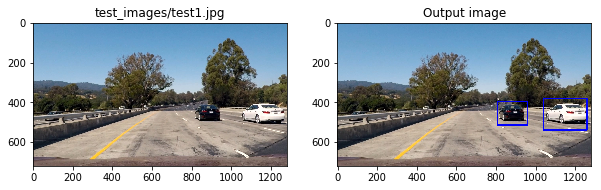

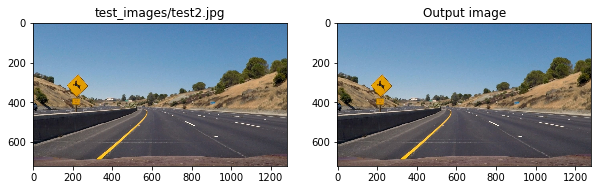

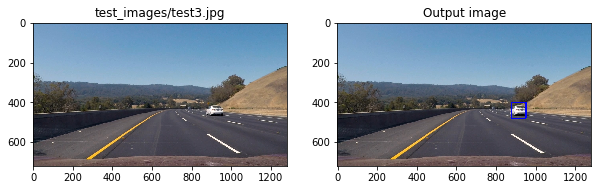

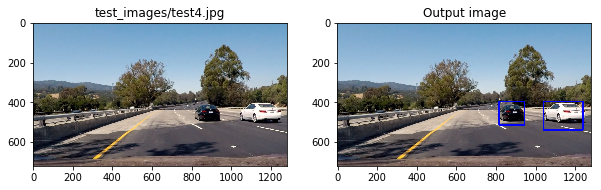

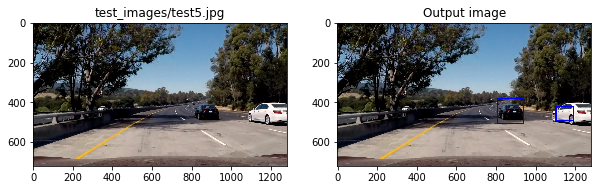

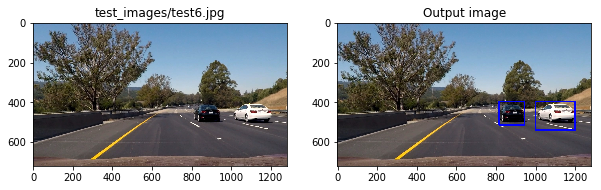

In [224]:
# plot test images with finalized pipeline
for imagename in glob.glob("test_images/*.jpg"):
    
    img = mpimg.imread(imagename)
    app_image = pipeline_image(img)
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(img)
    plt.title(imagename)
    plt.subplot(122)
    plt.imshow(app_image)
    plt.title('Output image')
    fig.tight_layout()

In [225]:
video_input = VideoFileClip('test_video.mp4')
video_output = 'test_video_output.mp4'
processed_video = video_input.fl_image(pipeline)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4



 97%|█████████▋| 38/39 [01:20<00:02,  2.14s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 1min 20s, sys: 481 ms, total: 1min 20s
Wall time: 1min 21s


In [226]:
video_input = VideoFileClip('project_video.mp4')
video_output = 'project_video_output.mp4'
processed_video = video_input.fl_image(pipeline)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [45:51<00:02,  2.16s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 44min 59s, sys: 24.3 s, total: 45min 24s
Wall time: 45min 52s


In [ ]:
video_input = VideoFileClip('test.mp4')
video_output = 'test_ouput.mp4'
processed_video = video_input.fl_image(pipeline)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_ouput.mp4
[MoviePy] Writing video test_ouput.mp4


 40%|███▉      | 189/473 [11:42<12:12,  2.58s/it]  

In [80]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))